In [1]:
import sys
sys.path.append('../../')

# from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
from hnlpy.timeop import makefiltersos
from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
# from scipy.signal import savgol_filter
# from scipy.fftpack import fft
# from scipy import stats # for zscoring

from sklearn.covariance import GraphicalLassoCV

# from numpy.polynomial.polynomial import polyfit, polyval

import matplotlib.pyplot as plt

/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, 

In [2]:
# load data
def loaddata(filename):
    data = loadmat(filename)
    bpchan = int(data['bpchan'][0][0])
    channels = data['channels'][0]
    conditionNames = data['conditionNames'][0]
    conditions = data['conditions'][0]
    eeg = dict()
    eeg[0] = data['dataL'][0]
    eeg[1] = data['dataR'][0]
    intervals = data['intervals'][0]
    labels = data['labels'][0]
    samples = data['samples'][0]
    session = int(data['session'][0])
    sessionTypes = data['sessionTypes'][0]
    sr = int(data['sr'][0])
    #Labels and condition names doesnt come over cleanly from matlab 
    chan_labels = list()
    condition_Names = list()
    #pythonify condition index
    condition_index = list()
    for j in range(len(labels)):
        chan_labels.append(labels[j][0])
    for j in range(len(conditionNames)):
        condition_Names.append(conditionNames[j][0])
    for j in range(12):
        condition_index.append(int(conditions[j]-1))
    return eeg, intervals, samples, condition_index, session, sr, bpchan, condition_Names, channels, chan_labels, sessionTypes 

In [3]:
def avref(datax):
	ref = np.mean(datax,axis = 1)
	refmat = np.tile(ref,(np.shape(datax)[1],1))
	datax = datax - np.transpose(refmat)
	return datax

In [4]:
# build the narrow band filters
srnew = 200 
downsample = 10 
passbands = [[1,3],[3.5,6.5],[7,10],[10.5,13.5],[14 ,20],[21,29],[30,49.5]]
stopbands = [[0.75,3.25],[3.25,6.75],[6.75,10.25],[10.25,13.75],[13.75,20.5],[20.5,29.5],[29.5,50]]
bandlabels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']
esos = dict()
for j in range(len(passbands)):
    esos[j],w,h = narrowfilter(passbands[j],stopbands[j],samplingrate = srnew)


In [5]:
# organize file in time sequence
filedir="../../"
pathname = 'Cleaned_data/'
filedates=[20220713,20220721,20220804,20220808,20220810,20220811,20220815,20220816,20221003,2022100401,2022100402,20221005]
numSes=len(filedates)

In [6]:
# lasso parameters
ncv = 5
pc_lasso = GraphicalLassoCV(cv=ncv)

In [9]:
# concatenate ampdata into 7 bands
abs_hilbert7_append =  [[] for i in range(7)]
for ses in range(12):
    filename='clean_'+str(filedates[ses])+'.mat'
    [eeg, intervals, samples, condition_index, session, sr, bpchan, 
                condition_Names, channels, chan_labels, sessionTypes] \
                    = loaddata(filedir+pathname+filename)
    #make a low pass filter @ 50 Hz 
    sos_low, w,h = makefiltersos(sr,50,55)
    empirical_ampcorr = np.zeros((12,2,7,32,32))
    parcor = np.zeros((12,2,7,32,32))
    for trial in range(12):
        nsamp1 = np.shape(eeg[0][trial])[0]
        nsamp2 = np.shape(eeg[1][trial])[0]
        nsamp = np.min((nsamp1,nsamp2))
        for subject in range(2): 
            trialdata = avref(eeg[subject][trial][0:nsamp,0:32]) 
            trialdata = sosfiltfilt(sos_low,trialdata,axis=0)
            trialdatanew = trialdata[range(0,nsamp,downsample),:]
            for frequency in range(7):
                        filtdata = sosfiltfilt(esos[frequency],trialdatanew,axis = 0,padtype ='odd')
                        hilbertdata = hilbert(filtdata,axis = 0)
                        ampdata=np.abs(hilbertdata)
                        abs_hilbert7_append[frequency].append(ampdata)

# take 8 min

In [45]:
# concatenate all 288 trials in each bend
amp_hilbert7_append =  [[] for i in range(7)]
parcor = np.zeros((7,32,32))
for freq in range(7):
        amp_hilbert7_append[freq]=np.concatenate(abs_hilbert7_append[freq])
        pc_lasso.fit(amp_hilbert7_append[freq])
        precision = pc_lasso.precision_
        y = np.diag(precision)
        yy = np.outer(y,y)
        yy = np.sqrt(yy)
        parcor[freq] = precision/yy
# take 14 min


/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:442: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fold_sizes = np.full(n_splits, n_samples // n_splits, dtype=np.int)
/home/zhibinz2/anaconda3/envs/eeg/lib/python3.9/site-packages/sklearn/model_selection/_split.py:102: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bo

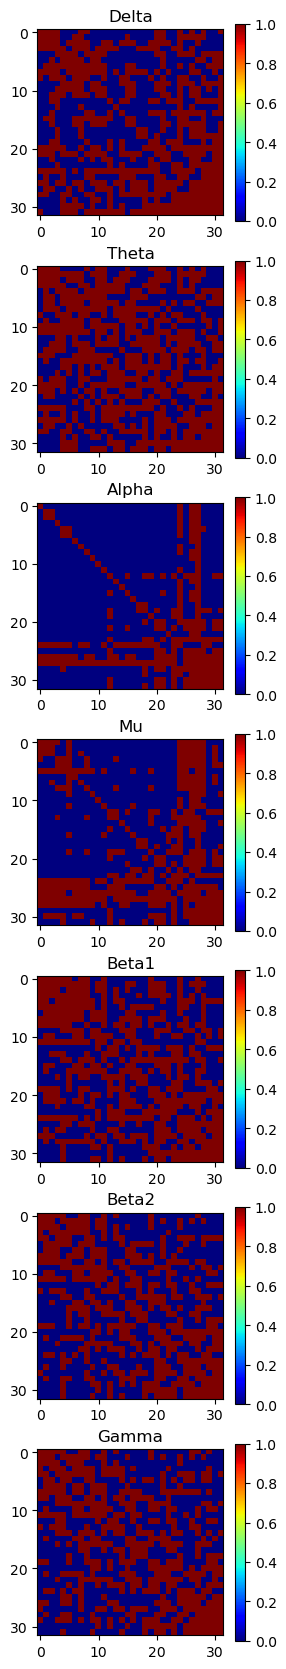

In [49]:
fig, ax = plt.subplots(7,1,figsize=(3, 3*7))
for freq in range(7):
    plt.sca(ax[freq])
    plt.imshow(parcor[freq].astype(bool), cmap='jet')
    plt.title(bandlabels[freq])
    plt.colorbar()

In [50]:
outdict = dict()
outdict['eeg_7band_pacorr'] = parcor
outdict['new_sr'] = srnew
outdict['passbands'] = passbands
outdict['stopbands'] = stopbands
outdict['band_labels'] = bandlabels
outdict['channels'] = channels
outdict['channel_labels'] = chan_labels
savemat('eeg_7band_pacorr',outdict,store_python_metadata = True) 